In [1]:
import io
import os
import shutil
import requests
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

%matplotlib inline

# Step 1: Download the input text files and concatenate to a dataframe

In [ ]:
def download_and_unpack_data(base_url: str, filename: str):
    """
    Download the compressed data from the file server and unpack
    """
    
    # download to local workspace
    cf = requests.get(base_url + filename, allow_redirects=True)
    with open(os.path.join('inputs',filename), 'wb') as f:
        f.write(cf.content)
    
    # unpack the compressed file
    shutil.unpack_archive("inputs/{}".format(filename), extract_dir="inputs")
    
def create_dataframe_from_txt_files(dataset, label):
    """
    create a pandas dataframe by parsing all spam and ham text files from the data folder
    """
    
    #files
    f_path = "inputs/{}/{}/".format(dataset, label)
    files = os.listdir(f_path)
    f_data = [open(f_path + f,encoding="ISO-8859-1").read() for f in files] 
    df = pd.DataFrame(data=list(zip(files, f_data)), columns=["filename", "body"])
    df["label"] = label
    
    return df

def create_dataframe(dataset: str):
    
    # get ham and spam data into dataframes
    dataframes = [create_dataframe_from_txt_files(dataset, label) for label in ["ham", "spam"]]
    
    # concat dataframes
    combined_df = pd.concat(dataframes)
    
    # add dataset tag
    combined_df["dataset"] = dataset
    
    return combined_df
    

# create inputs folder
os.makedirs("inputs", exist_ok=True)

# download input data 
base_url = "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/"
filenames = ["enron{}.tar.gz".format(x) for x in range(1,7)]

for file in filenames:
    print(file)
    download_and_unpack_data(base_url, file)
    
# get text data from each enron folder into a dataframe
enron_dfs = [create_dataframe("enron{}".format(x)) for x in range(1, 7)]

# concat dataframes
enron_combined = pd.concat(enron_dfs)

#save file
enron_combined.to_csv("inputs/Enron_Emails_Dataset.csv")

enron_combined.head()

# Step 2: Explore the dataset and tokenize email messages

## Plot of label distributions
* If we look at all the emails together, there are roughly equal number  `ham` and `spam` emails. In that sense its a balanced dataset.

In [2]:
input_path = "inputs/Enron_Emails_Dataset.csv"

if ("enron_combined" not in locals()) and os.path.isfile(input_path):
    enron_combined = pd.read_csv(input_path, index_col=[0])
else:
    print("Run previous cells to generate input dataset")

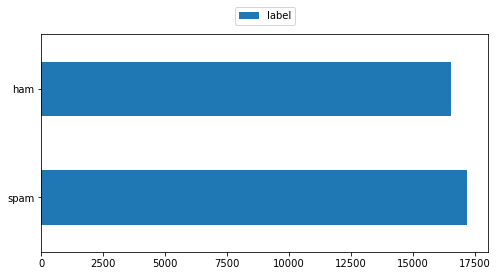

In [3]:
enron_combined["label"].value_counts().plot.barh(figsize=(8,4))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

### create binary label

In [4]:
mapping = {'spam': 1, 'ham': 0}
enron_combined["binary_label"] = enron_combined["label"].replace(mapping)
enron_combined.head()

,filename,body,label,dataset,binary_label
0,2983.2000-11-30.farmer.ham.txt,Subject: tri - c / cokinos gov bill daniels de...,ham,enron1,0
1,1571.2000-06-30.farmer.ham.txt,"Subject: preliminary "" buyback & deficiency de...",ham,enron1,0
2,3068.2000-12-12.farmer.ham.txt,"Subject: meter 8741 / 1587 nov 00\ndaren ,\ni ...",ham,enron1,0
3,4465.2001-05-02.farmer.ham.txt,Subject: cliff baxter\nit is with sadness and ...,ham,enron1,0
4,4480.2001-05-03.farmer.ham.txt,Subject: gulf coast pipeline company dyersdale...,ham,enron1,0


## Distribution of length of email messages
* The length of email messages show a skewed distribution. About 85% of the emails have less than 500 words. 30% of the messages have (10, 100) words. A small number of messages have less than 10 or more than 1000 words.
* For the purpose of tokenizing and encoding the sentences, we pick a `padding length = 500` based on the sentence length distribution

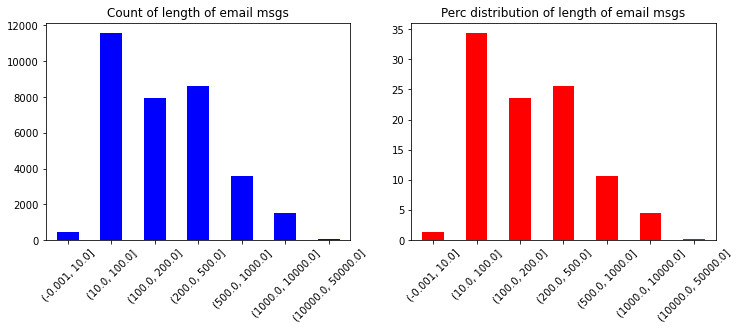

In [5]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in enron_combined["body"]]
s = pd.Series(seq_len)

out = pd.cut(s, bins=[0, 10, 100, 200, 500, 1000, 10000, 50000], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)

fig,axs = plt.subplots(1,2, figsize=(12,4))
out.value_counts(sort=False).plot.bar(rot=45, color="b", ax=axs[0], title="Count of length of email msgs")
out_norm.plot.bar(rot=45, color="r", ax=axs[1], title="Perc distribution of length of email msgs")
plt.show()

## Train, Validate, Test Split

In [6]:
# split train dataset into train and test sets
train_text, test_text, train_labels, test_labels = train_test_split(enron_combined['body'].to_numpy(), 
                                                                    enron_combined['binary_label'].to_numpy(), 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=enron_combined['binary_label'])

## BERT Tokenizer

In [7]:
%%time

from BERT import TextTokenize

# instantiate class
tokenizer = TextTokenize()

pad_length = 500 # set pad length based on sentence length distribution
save_dir = "inputs/saved_tensors"

# tokenize and encode sequences in the training set
tokenizer.token_and_encode(train_text, train_labels, pad_length, save_dir, "train")

# tokenize and encode sequences in the test set
tokenizer.token_and_encode(test_text, test_labels, pad_length, save_dir, "test")

# tokenize and encode sequences in the validation set
# input_ids_val, att_mask_val = tokenizer.token_and_encode(val_text, val_labels, pad_length, save_dir, "val")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

CPU times: user 45.4 s, sys: 1.87 s, total: 47.2 s
Wall time: 29 s


In [8]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/spam_detection_bert'


input_data = sagemaker_session.upload_data(path=save_dir, bucket=bucket, key_prefix=prefix)

In [9]:
from sagemaker.debugger import TensorBoardOutputConfig

emit_dir = "sagemaker/spam_detection_bert/training_logs"
tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path= "{}/{}".format(bucket, emit_dir),
    container_local_output_path='/opt/ml/output/tensorboard/')

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="BERT",
                    role=role,
                    framework_version='1.4.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.p2.xlarge',
                    debugger_hook_config=False,
                    hyperparameters={
                        'epochs': 10,
                        'batch_size':100,
                        'k_fold':3
                    })

In [ ]:
estimator.fit({'training': input_data})

2021-02-09 02:27:39 Starting - Starting the training job...
2021-02-09 02:28:03 Starting - Launching requested ML instancesProfilerReport-1612837658: InProgress
......
2021-02-09 02:29:03 Starting - Preparing the instances for training............
2021-02-09 02:31:09 Downloading - Downloading input data...
2021-02-09 02:31:34 Training - Downloading the training image.........
2021-02-09 02:33:06 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-09 02:33:02,286 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-02-09 02:33:02,312 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-09 02:33:05,342 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-02-09 02:33:05,731 sagemaker-containers INFO     Module default_user_module_name does not prov